In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

In [3]:
data=pd.read_csv('AML_DeepLearningFundamentals.csv')

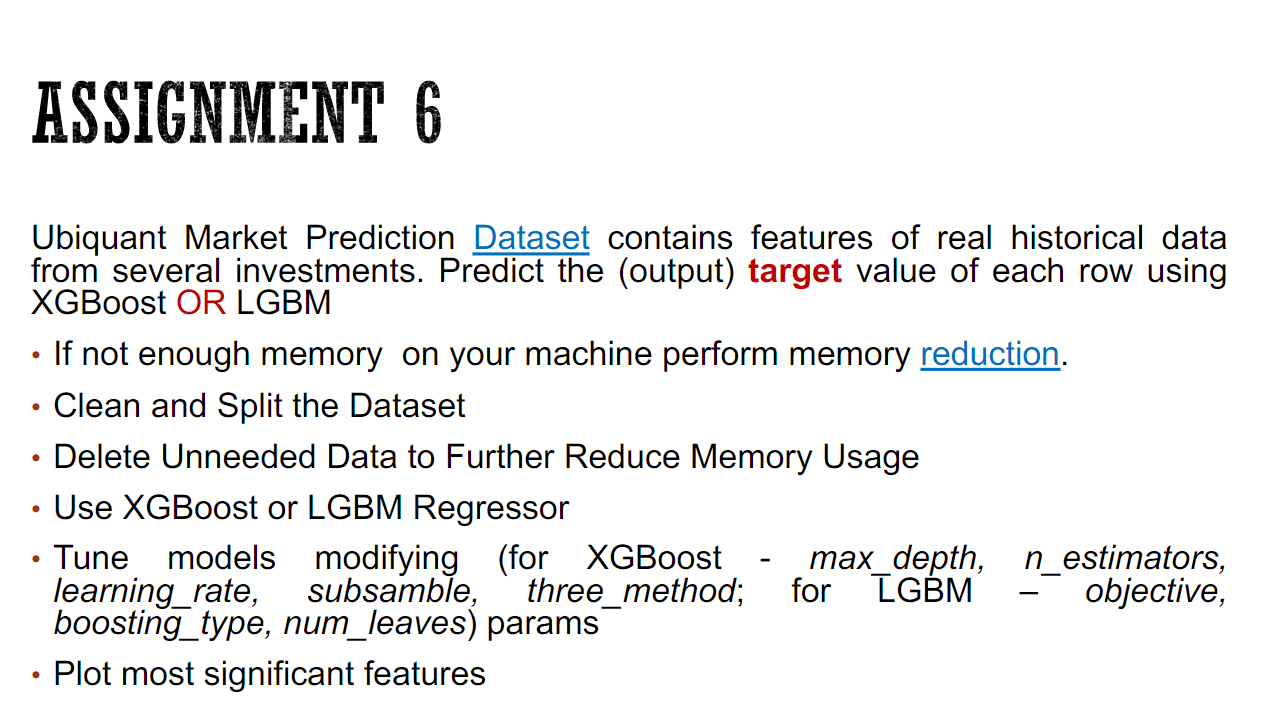

In [4]:
data

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1190_2701,1190,2701,-0.413300,-0.31980,1.0980,0.55370,-0.3457,-0.2920,0.8450,...,-0.7266,0.22250,-0.5330,0.36770,1.0740,-0.4387,0.23100,0.346000,-0.2157,-0.44340
1,1190_2702,1190,2702,-0.011444,0.83500,0.3555,-0.93360,0.7495,-0.1852,-0.1455,...,0.8060,-2.19000,-0.3770,0.03293,-1.2790,-0.2740,-1.22700,-0.006516,1.2880,0.80270
2,1190_2703,1190,2703,-0.670000,-3.86000,-1.2470,-0.56930,0.1724,-0.0315,1.7280,...,-0.2042,0.59130,-0.4517,0.34450,1.3670,-0.3726,2.19100,1.145000,-0.7150,0.01503
3,1190_2704,1190,2704,-0.615700,-2.22000,-2.2750,-0.56800,0.0466,-0.1558,1.2190,...,-0.5600,-1.07300,-1.0205,-0.77100,-0.8180,-0.2473,-1.17100,-3.111000,0.2384,-0.49630
4,1190_2705,1190,2705,-0.660000,0.86670,0.2670,0.00855,-0.8022,-0.0814,-1.2950,...,-0.9355,0.07623,-1.1030,-0.16830,1.5460,-0.2102,1.06300,0.335200,1.0890,-0.11900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1219_3768,1219,3768,0.033600,0.09350,-0.7200,-0.34550,-0.4387,-0.1670,-0.4373,...,-0.2860,-1.23200,-0.6606,0.87550,0.4216,-0.4280,-0.07556,-0.533000,-0.1937,-0.58150
99996,1219_3769,1219,3769,-0.223300,-1.34500,-0.2000,-0.10770,-0.4546,-0.2219,-0.1411,...,0.1846,-1.23200,-0.6704,0.87550,0.4216,-0.7300,-1.51500,0.013145,-0.8900,-0.59000
99997,1219_3770,1219,3770,-0.559600,0.97950,-1.1100,1.00700,-0.4673,-0.1595,1.3550,...,-0.7563,-1.23200,0.8210,-1.14300,0.4216,-0.3633,1.36300,-0.079100,-1.5800,-0.29760
99998,1219_3772,1219,3772,0.009600,-2.56400,0.3203,0.07660,1.3800,-0.1554,-0.6890,...,-0.7563,-1.23200,0.1330,-1.14300,0.4216,-0.3752,-1.51500,-0.973600,0.6090,-0.37200


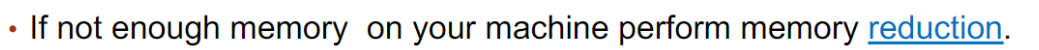

In [5]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [6]:
print('-' * 80)
print('train')
train = import_data(r'C:\Users\фора\Downloads\AML_DeepLearningFundamentals\AML_DeepLearningFundamentals.csv')

--------------------------------------------------------------------------------
train
Memory usage of dataframe is 231.93 MB
Memory usage after optimization is: 61.44 MB
Decreased by 73.5%


In [7]:
for i in train.dtypes:
    print(i)

category
int16
int16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
flo

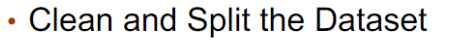

In [8]:
train.dropna()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1190_2701,1190,2701,-0.413330,-0.319824,1.097656,0.553711,-0.345703,-0.291992,0.845215,...,-0.726562,0.222534,-0.533203,0.367676,1.074219,-0.438721,0.230957,0.345947,-0.215698,-0.443359
1,1190_2702,1190,2702,-0.011444,0.834961,0.355469,-0.933594,0.749512,-0.185181,-0.145508,...,0.806152,-2.189453,-0.376953,0.032928,-1.279297,-0.273926,-1.226562,-0.006516,1.288086,0.802734
2,1190_2703,1190,2703,-0.669922,-3.859375,-1.247070,-0.569336,0.172363,-0.031494,1.727539,...,-0.204224,0.591309,-0.451660,0.344482,1.367188,-0.372559,2.191406,1.144531,-0.714844,0.015030
3,1190_2704,1190,2704,-0.615723,-2.220703,-2.275391,-0.567871,0.046600,-0.155762,1.218750,...,-0.560059,-1.073242,-1.020508,-0.770996,-0.817871,-0.247314,-1.170898,-3.111328,0.238403,-0.496338
4,1190_2705,1190,2705,-0.660156,0.866699,0.267090,0.008553,-0.802246,-0.081421,-1.294922,...,-0.935547,0.076233,-1.102539,-0.168335,1.545898,-0.210205,1.063477,0.335205,1.088867,-0.119019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1219_3768,1219,3768,0.033600,0.093506,-0.720215,-0.345459,-0.438721,-0.166992,-0.437256,...,-0.285889,-1.232422,-0.660645,0.875488,0.421631,-0.427979,-0.075562,-0.533203,-0.193726,-0.581543
99996,1219_3769,1219,3769,-0.223267,-1.344727,-0.199951,-0.107727,-0.454590,-0.221924,-0.141113,...,0.184570,-1.232422,-0.670410,0.875488,0.421631,-0.729980,-1.514648,0.013145,-0.890137,-0.589844
99997,1219_3770,1219,3770,-0.559570,0.979492,-1.110352,1.006836,-0.467285,-0.159546,1.355469,...,-0.756348,-1.232422,0.820801,-1.142578,0.421631,-0.363281,1.363281,-0.079102,-1.580078,-0.297607
99998,1219_3772,1219,3772,0.009598,-2.564453,0.320312,0.076599,1.379883,-0.155396,-0.688965,...,-0.756348,-1.232422,0.133057,-1.142578,0.421631,-0.375244,-1.514648,-0.973633,0.608887,-0.372070


In [9]:
train['row_id'].dtype

CategoricalDtype(categories=['1190_2701', '1190_2702', '1190_2703', '1190_2704',
                  '1190_2705', '1190_2706', '1190_2707', '1190_2708',
                  '1190_2710', '1190_2711',
                  ...
                  '1219_99', '1219_990', '1219_991', '1219_992', '1219_993',
                  '1219_994', '1219_995', '1219_996', '1219_997', '1219_999'],
                 ordered=False)

In [10]:
train = train.astype({'row_id':'float'})
train = train.astype({'time_id':'float'})

In [11]:
y=train.iloc[:,0:4]
y=y.iloc[:,3:4]

In [12]:
X=train.drop(['target'],1)

In [13]:
X

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,11902701.0,1190.0,2701,-0.319824,1.097656,0.553711,-0.345703,-0.291992,0.845215,1.138672,...,-0.726562,0.222534,-0.533203,0.367676,1.074219,-0.438721,0.230957,0.345947,-0.215698,-0.443359
1,11902702.0,1190.0,2702,0.834961,0.355469,-0.933594,0.749512,-0.185181,-0.145508,-0.627441,...,0.806152,-2.189453,-0.376953,0.032928,-1.279297,-0.273926,-1.226562,-0.006516,1.288086,0.802734
2,11902703.0,1190.0,2703,-3.859375,-1.247070,-0.569336,0.172363,-0.031494,1.727539,0.417969,...,-0.204224,0.591309,-0.451660,0.344482,1.367188,-0.372559,2.191406,1.144531,-0.714844,0.015030
3,11902704.0,1190.0,2704,-2.220703,-2.275391,-0.567871,0.046600,-0.155762,1.218750,-1.126953,...,-0.560059,-1.073242,-1.020508,-0.770996,-0.817871,-0.247314,-1.170898,-3.111328,0.238403,-0.496338
4,11902705.0,1190.0,2705,0.866699,0.267090,0.008553,-0.802246,-0.081421,-1.294922,1.856445,...,-0.935547,0.076233,-1.102539,-0.168335,1.545898,-0.210205,1.063477,0.335205,1.088867,-0.119019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12193768.0,1219.0,3768,0.093506,-0.720215,-0.345459,-0.438721,-0.166992,-0.437256,1.475586,...,-0.285889,-1.232422,-0.660645,0.875488,0.421631,-0.427979,-0.075562,-0.533203,-0.193726,-0.581543
99996,12193769.0,1219.0,3769,-1.344727,-0.199951,-0.107727,-0.454590,-0.221924,-0.141113,-1.498047,...,0.184570,-1.232422,-0.670410,0.875488,0.421631,-0.729980,-1.514648,0.013145,-0.890137,-0.589844
99997,12193770.0,1219.0,3770,0.979492,-1.110352,1.006836,-0.467285,-0.159546,1.355469,0.150757,...,-0.756348,-1.232422,0.820801,-1.142578,0.421631,-0.363281,1.363281,-0.079102,-1.580078,-0.297607
99998,12193772.0,1219.0,3772,-2.564453,0.320312,0.076599,1.379883,-0.155396,-0.688965,0.381104,...,-0.756348,-1.232422,0.133057,-1.142578,0.421631,-0.375244,-1.514648,-0.973633,0.608887,-0.372070


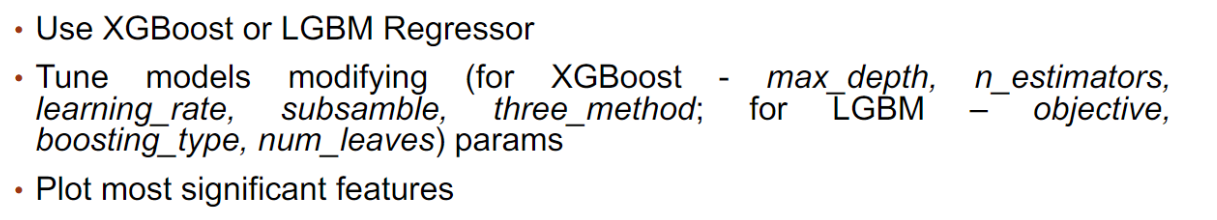

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [16]:
X_test

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
75721,12123493.0,1212.0,3493,0.294189,0.954102,0.693848,-0.494141,-0.004208,0.270264,1.185547,...,1.380859,1.297852,0.683105,0.484131,-0.778320,0.170654,-1.713867,-0.320312,0.733398,-0.032928
80184,1214852.0,1214.0,852,0.347900,0.953613,-0.544922,-0.405273,-0.175537,1.130859,1.922852,...,-0.274170,-0.718262,2.689453,0.920410,-0.713379,-0.290527,1.051758,-0.700195,-1.036133,-0.286865
19864,11962251.0,1196.0,2251,-1.690430,-0.411377,-1.324219,-0.486816,-0.041016,0.790527,1.174805,...,0.222290,-0.615723,0.605469,0.368652,-1.298828,0.651855,0.775391,0.373535,1.682617,0.116150
76699,1213800.0,1213.0,800,-1.624023,0.420410,0.382080,0.208618,0.000245,-1.137695,0.497559,...,0.272705,1.574219,3.685547,1.114258,-1.272461,0.843750,-0.360352,1.541992,1.208984,0.180786
92991,12173621.0,1217.0,3621,-5.332031,-0.736816,-0.262695,-0.369629,-0.168701,-0.745117,0.078918,...,-0.648926,0.605469,-0.636230,0.405518,0.675293,-0.329590,-0.736328,2.679688,-0.792480,-0.382324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97545,12191098.0,1219.0,1098,0.843262,-1.110352,-0.012383,-0.442139,-0.193115,1.291992,-0.158936,...,1.595703,0.811523,0.220093,-1.142578,0.421631,-0.440430,-0.075562,-0.099426,-1.736328,-0.510742
15490,11951173.0,1195.0,1173,1.909180,-2.064453,1.052734,-0.543945,-0.143555,0.640137,1.335938,...,-0.169067,-3.134766,-0.470703,0.154297,-0.090515,-0.278320,0.528320,0.580078,-1.626953,-0.204102
62384,1209175.0,1209.0,175,-2.437500,0.627930,-0.666016,0.204834,-0.123657,1.564453,0.911133,...,-0.493652,1.053711,0.674805,0.464355,-0.703125,-0.535156,-0.261719,-0.958496,-0.565430,-0.067444
54594,12062945.0,1206.0,2945,0.332764,1.224609,0.977539,-0.363281,-0.167603,-0.157593,1.195312,...,0.855469,2.468750,3.900391,0.226196,-0.272949,-0.510254,-2.550781,0.331543,0.023010,-0.335693


In [17]:
predictions = my_model.predict(X_test)
predictions

array([-0.1906847 ,  0.05092928, -0.09883237, ..., -0.09950196,
        0.35435855,  0.21800935], dtype=float32)

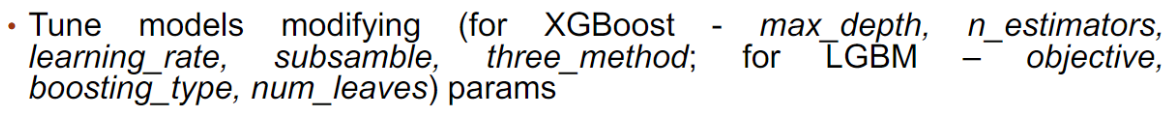

In [18]:
X_train

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
59428,1208709.0,1208.0,709,0.763672,0.360352,-2.099609,8.710938,0.408447,0.429688,0.427490,...,1.783203,-0.604492,0.866699,0.627441,-0.345947,2.765625,-0.907715,-0.465332,2.412109,1.673828
34957,1201116.0,1201.0,116,0.875977,0.240601,-2.660156,-0.084290,1.092773,2.195312,-0.961426,...,0.199463,0.500488,-0.158447,1.504883,-0.078796,2.080078,-0.077759,0.197754,0.269531,2.523438
4264,11913707.0,1191.0,3707,0.619141,1.055664,-0.276855,1.444336,-0.238647,0.934570,-0.764160,...,1.300781,-1.635742,0.233765,-0.174805,1.286133,-1.851562,0.538086,-3.068359,1.168945,-0.856934
53791,12062055.0,1206.0,2055,1.327148,-2.101562,2.189453,-0.409912,-0.085266,-0.441650,-2.562500,...,0.328857,0.278320,1.160156,0.024155,0.272949,0.383057,-1.532227,-0.640625,0.333008,0.015793
82114,12142964.0,1214.0,2964,0.534668,0.221436,0.559570,-0.448242,-0.055786,1.123047,0.437988,...,-0.255859,-0.718262,-1.087891,0.920410,-0.713379,-0.332031,1.051758,0.129639,-1.316406,-0.385742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,11922163.0,1192.0,2163,1.114258,0.361572,-0.584961,-0.355225,0.017456,-0.006767,-1.527344,...,-0.656250,1.079102,-0.710449,0.538086,-3.966797,0.045319,-0.727539,2.201172,-0.925781,-0.062073
54886,12063265.0,1206.0,3265,1.850586,0.158203,0.721680,-0.492432,-0.159790,0.120972,-0.554199,...,0.190918,-0.440186,-0.835938,-0.210938,2.777344,-0.697754,-1.705078,1.534180,-0.047058,-0.572754
76820,1213933.0,1213.0,933,-0.140259,0.270264,-0.181763,-0.470215,-0.179443,-0.490723,-1.173828,...,-0.947754,-0.635254,-1.173828,1.114258,-1.272461,-0.594727,0.859375,-0.047455,0.370850,-0.447266
860,11903657.0,1190.0,3657,-0.576172,-0.396973,0.281494,-0.784668,-0.160522,-1.811523,-0.234253,...,-0.843750,0.394775,-1.390625,0.691895,1.294922,-0.308594,0.448486,1.446289,-0.050446,-0.318359


In [ ]:
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()

parameters = {
              'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              'max_depth': [5, 6, 7],
              'n_estimators': [50, 150, 200, 250, 300, 350],
            'tree_method':['hist','exact','auto']}
   
grid = GridSearchCV(my_model, parameters, cv=5).fit(X_train, y_train)
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

print(grid.best_score_)
print(grid.best_params_)

In [ ]:
my_model.feature_importances_


In [ ]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()